In [1]:
import pyorc
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from dask.diagnostics import ProgressBar
from matplotlib import patches


In [2]:
cam_config = pyorc.load_camera_config("./ngwerere.json")
video_file = "./ngwerere_20191103.mp4"
# set coordinates that encapsulate the water surface at minimum. Areas outside will be used for stabilization
stabilize = [
    [150, 0],
    [500, 1079],
    [1750, 1079],
    [900, 0]
]
video = pyorc.Video(
    video_file,
    camera_config=cam_config,
    start_frame=0,
    end_frame=125,
    stabilize=stabilize,
    h_a=0.,
)
video


Scanning video: 100%|██████████| 126/126 [00:03<00:00, 41.91it/s]
Deriving stabilization parameters from second frame onwards: 100%|██████████| 125/125 [00:04<00:00, 29.47it/s]



Filename: ./ngwerere_20191103.mp4
FPS: 30.000000
start frame: 0
end frame: 125
Camera configuration: {
    "height": 1080,
    "width": 1920,
    "crs": "PROJCRS[\"WGS 84 / UTM zone 35S\",BASEGEOGCRS[\"WGS 84\",ENSEMBLE[\"World Geodetic System 1984 ensemble\",MEMBER[\"World Geodetic System 1984 (Transit)\"],MEMBER[\"World Geodetic System 1984 (G730)\"],MEMBER[\"World Geodetic System 1984 (G873)\"],MEMBER[\"World Geodetic System 1984 (G1150)\"],MEMBER[\"World Geodetic System 1984 (G1674)\"],MEMBER[\"World Geodetic System 1984 (G1762)\"],MEMBER[\"World Geodetic System 1984 (G2139)\"],MEMBER[\"World Geodetic System 1984 (G2296)\"],ELLIPSOID[\"WGS 84\",6378137,298.257223563,LENGTHUNIT[\"metre\",1]],ENSEMBLEACCURACY[2.0]],PRIMEM[\"Greenwich\",0,ANGLEUNIT[\"degree\",0.0174532925199433]],ID[\"EPSG\",4326]],CONVERSION[\"UTM zone 35S\",METHOD[\"Transverse Mercator\",ID[\"EPSG\",9807]],PARAMETER[\"Latitude of natural origin\",0,ANGLEUNIT[\"degree\",0.0174532925199433],ID[\"EPSG\",8801]],PARAMET

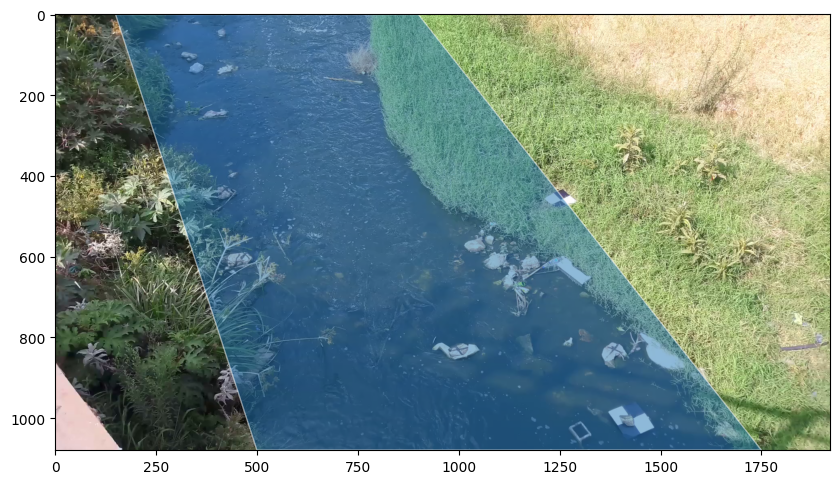

In [3]:
# some keyword arguments for fancy polygon plotting
patch_kwargs = {
    "alpha": 0.5,
    "zorder": 2,
    "edgecolor": "w",
    "label": "Area of interest",
}
f, ax = plt.subplots(1, 1, figsize=(10, 6))

frame = video.get_frame(0, method="rgb")
# plot frame on a notebook-style window
ax.imshow(frame)
# add the polygon to the axes
patch = patches.Polygon(
    stabilize,
    **patch_kwargs
)
p = ax.add_patch(patch)

In [4]:
da = video.get_frames()
da

<xarray.DataArray 'frames' (time: 126, y: 1080, x: 1920)> Size: 261MB
dask.array<concatenate, shape=(126, 1080, 1920), dtype=uint8, chunksize=(20, 1080, 1920), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1kB 0.0 0.03333 0.06667 0.1 ... 4.1 4.133 4.167
  * y        (y) int32 4kB 1079 1078 1077 1076 1075 1074 1073 ... 6 5 4 3 2 1 0
  * x        (x) int32 8kB 0 1 2 3 4 5 6 ... 1913 1914 1915 1916 1917 1918 1919
    xp       (y, x) int32 8MB 0 1 2 3 4 5 6 ... 1914 1915 1916 1917 1918 1919
    yp       (y, x) int32 8MB 1079 1079 1079 1079 1079 1079 1079 ... 0 0 0 0 0 0
Attributes:
    camera_shape:   [1080, 1920]
    camera_config:  {\n    "height": 1080,\n    "width": 1920,\n    "crs": "P...
    h_a:            0.0
    chunksize:      20

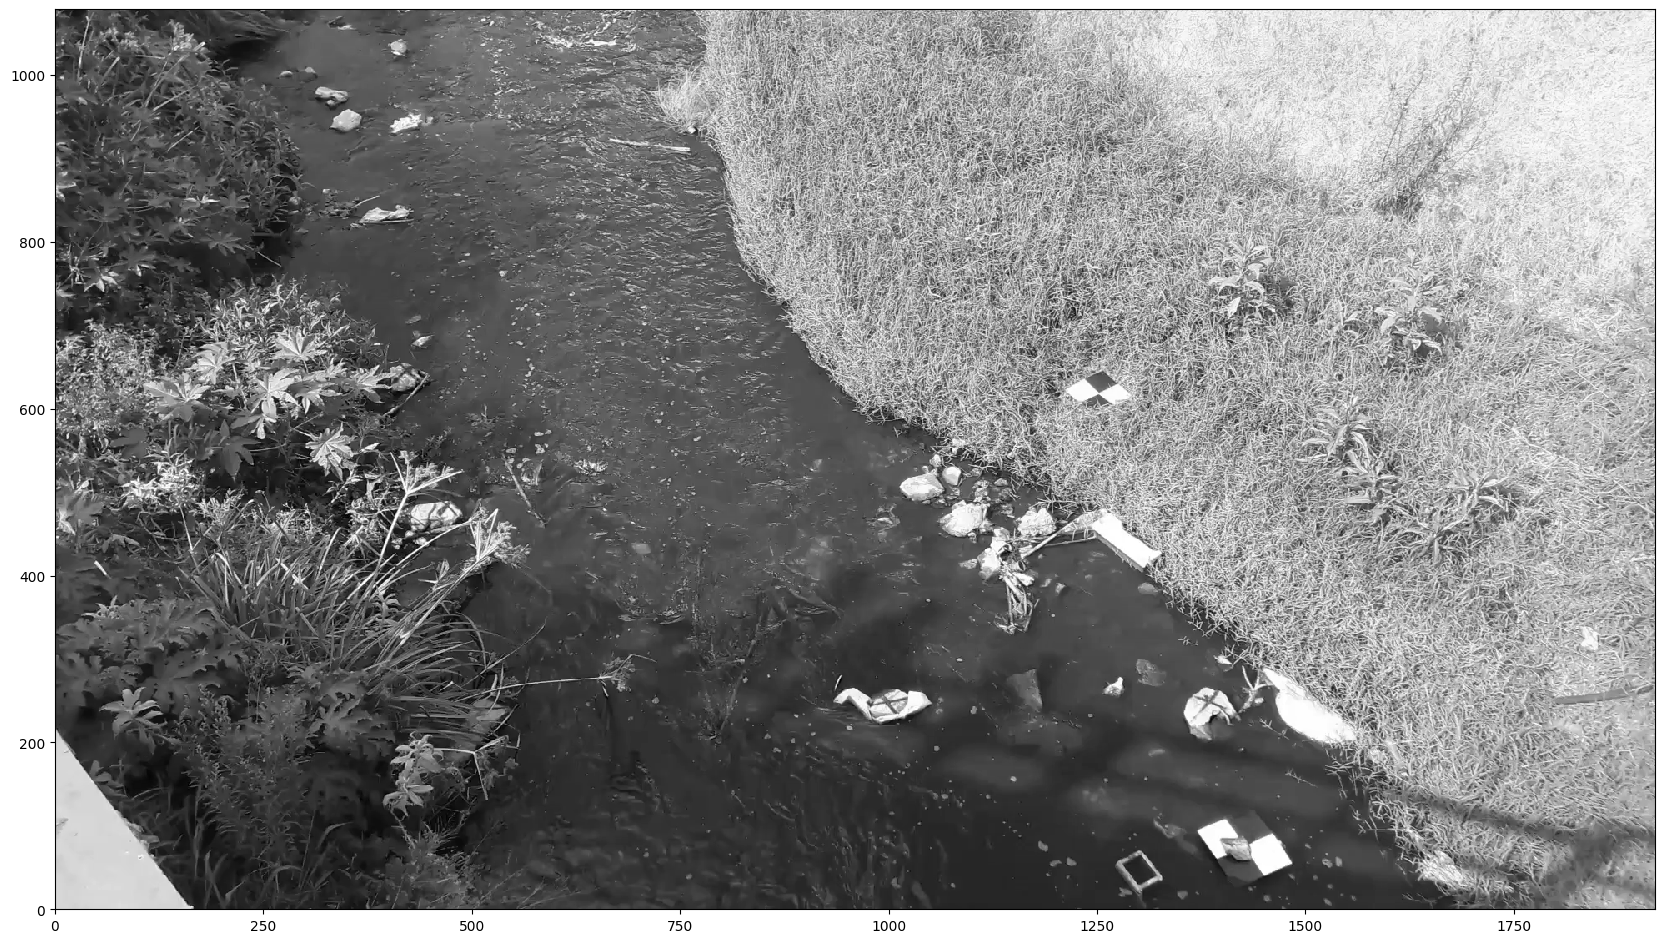

In [5]:
da[0].frames.plot(cmap="gray")

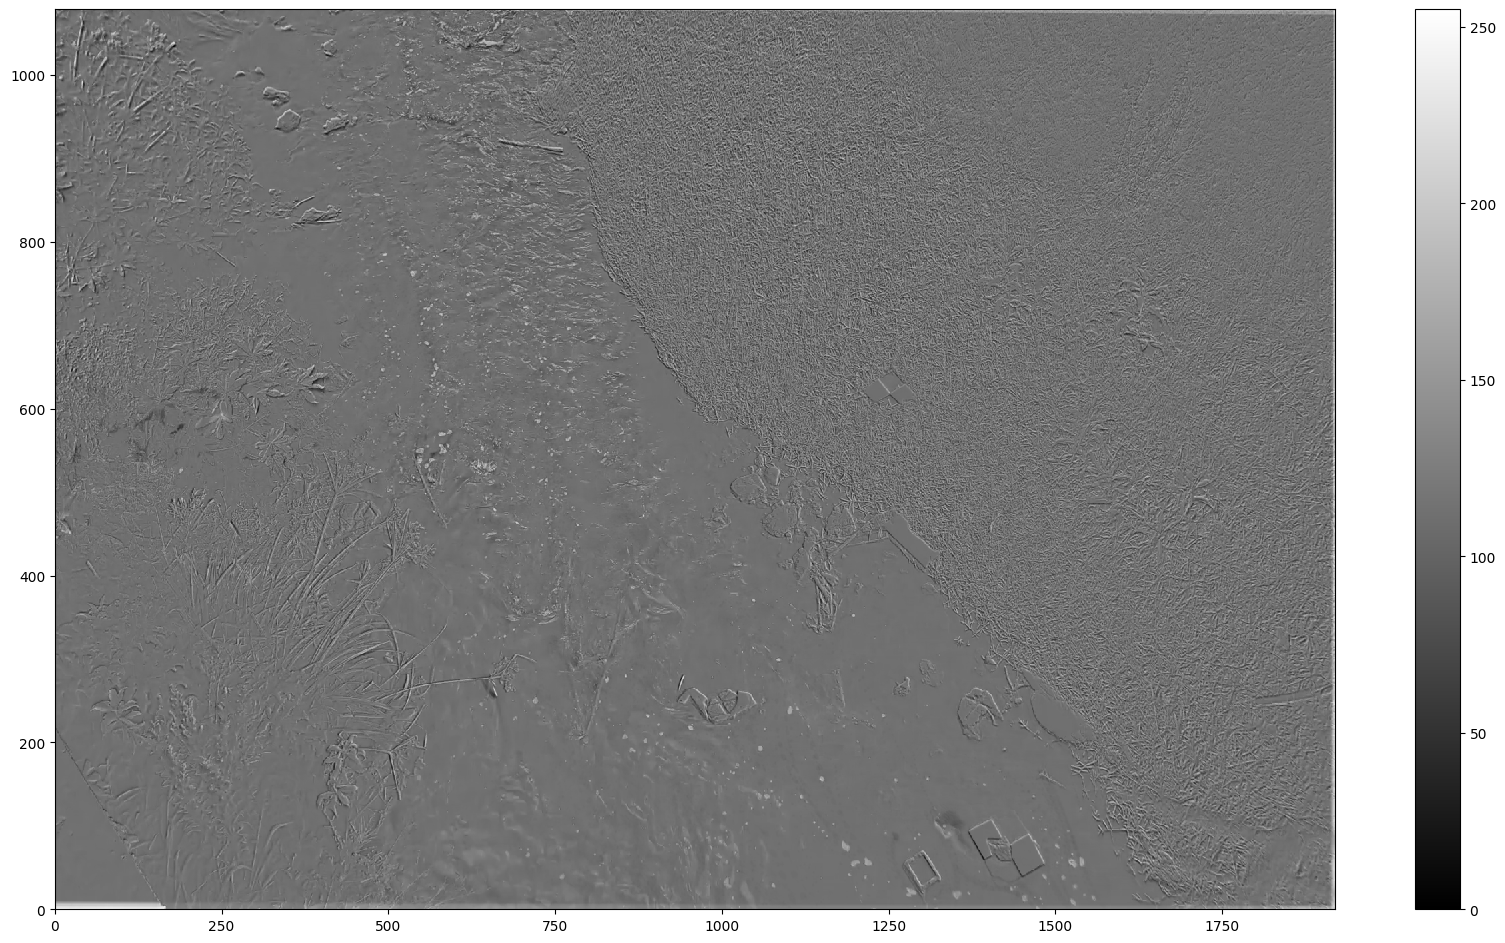

In [6]:
# da_norm = da.frames.time_diff(abs=False, thres=0.)
# da_norm = da_norm.frames.minmax(min=0.)
da_norm = da.frames.normalize()
p = da_norm[0].frames.plot(cmap="gray")
plt.colorbar(p)

<Figure size 1600x900 with 0 Axes>

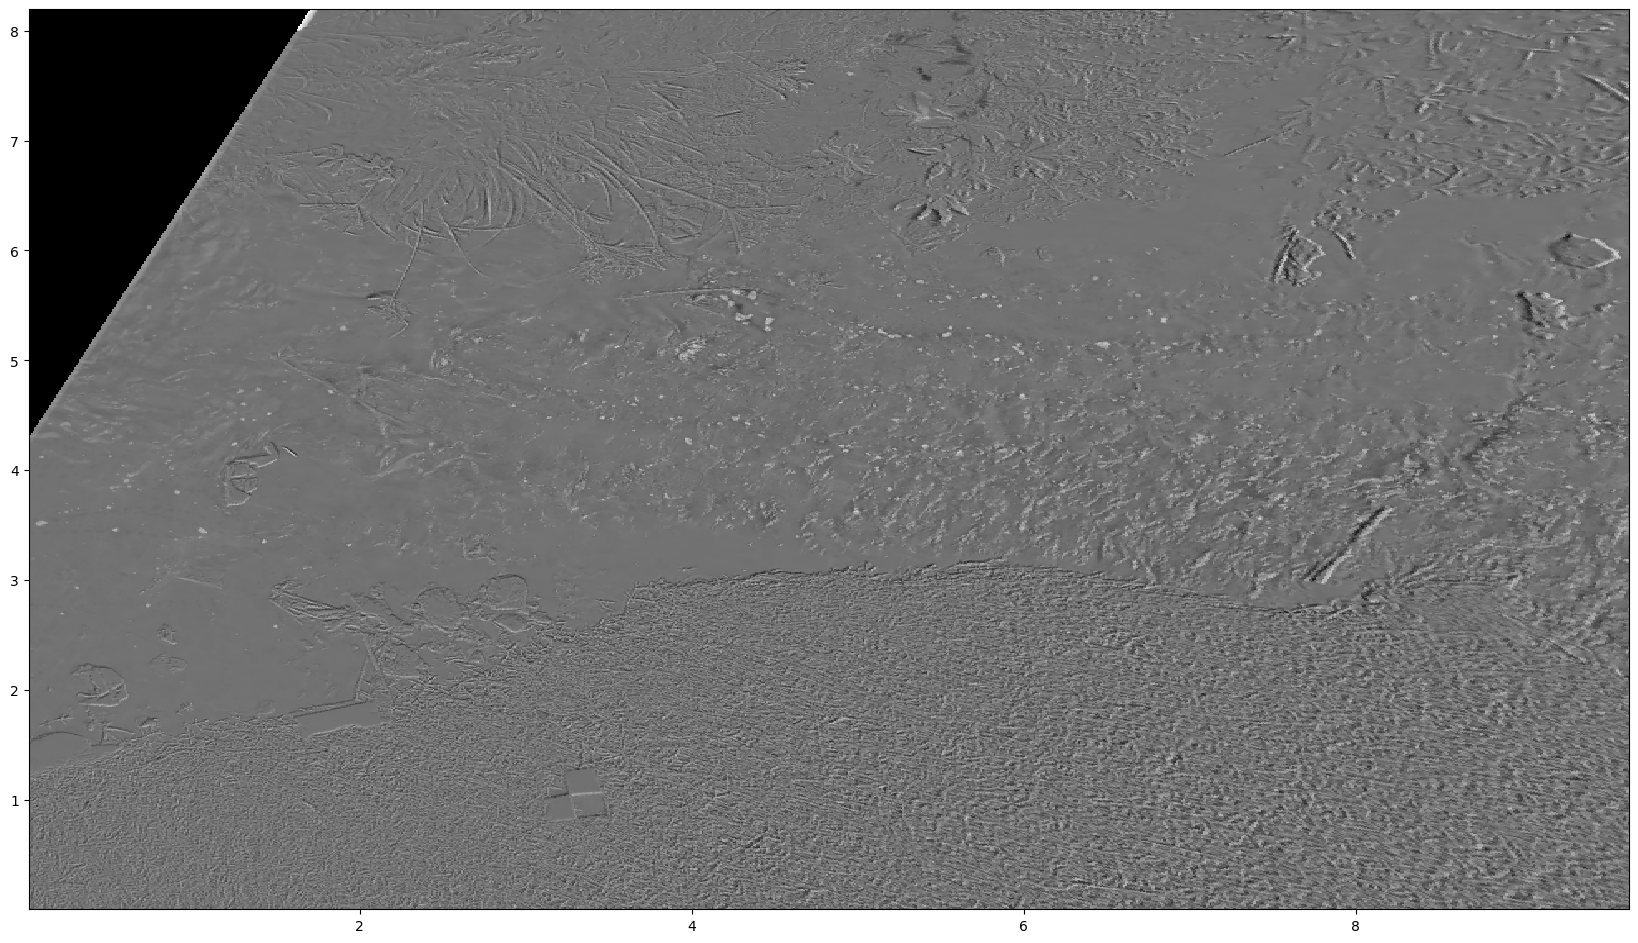

In [7]:
f = plt.figure(figsize=(16, 9))
da_norm_proj = da_norm.frames.project(method="numpy")
da_norm_proj[0].frames.plot(cmap="gray")

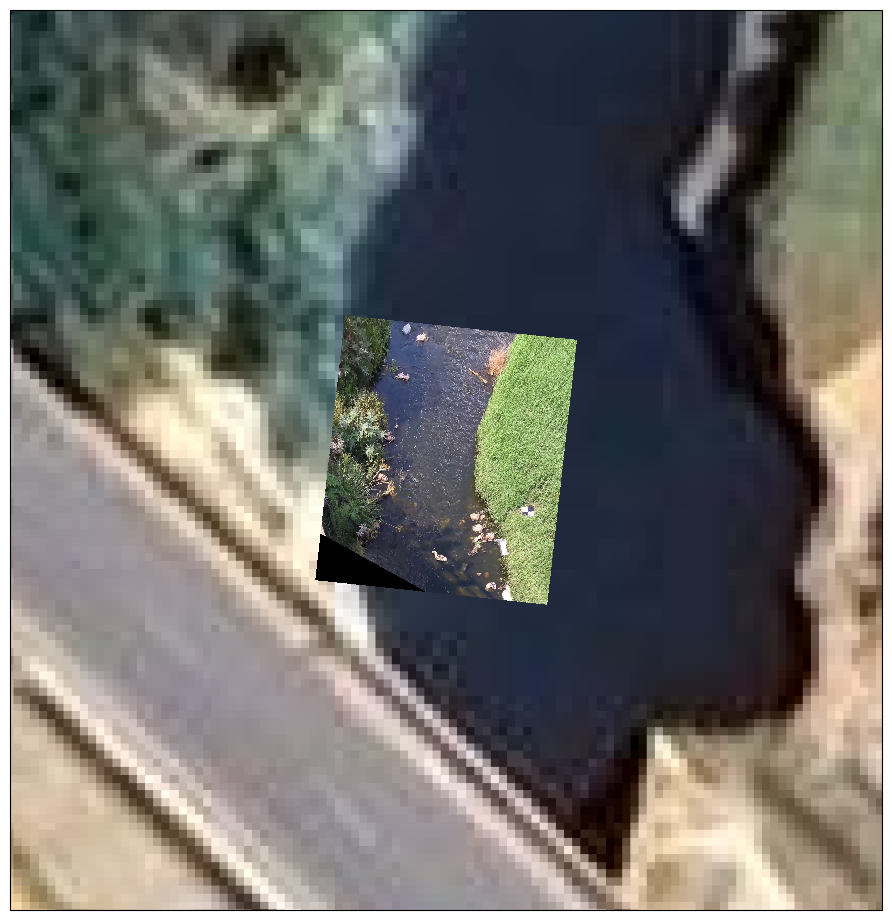

In [8]:
# extract frames again, but now with rgb
da_rgb = video.get_frames(method="rgb")
# project the rgb frames, same as before
da_rgb_proj = da_rgb.frames.project()
# plot the first frame in geographical mode
p = da_rgb_proj[0].frames.plot(mode="geographical")

# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.0001,
    da_rgb_proj.lon.max() + 0.0001,
    da_rgb_proj.lat.min() - 0.0001,
    da_rgb_proj.lat.max() + 0.0001],
    crs=ccrs.PlateCarree()
)

In [9]:
piv = da_norm_proj.frames.get_piv(engine="numba")
piv.to_netcdf("ngwerere_piv.nc")

Computing PIV per chunk: 100%|██████████| 1/1 [00:54<00:00, 54.17s/it]


In [10]:
type(da_norm_proj)


xarray.core.dataarray.DataArray